# Realizar predição e imagem resultado
1. Carregar as bandas
2. Filtrar região da água
3. Carregar modelo treinado
4. Predição dos pontos não conhecidos
5. Label de escala de profundidade

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tifffile
from pathlib import Path, PureWindowsPath
import pandas as pd
import tqdm
import cv2

## 1. Carregar as 8 bandas

In [4]:
b1 = tifffile.TiffFile("C:/Users/ricar/tccpy/data/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_443.tif")
b2 = tifffile.TiffFile("C:/Users/ricar/tccpy/data/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_492.tif")
b3 = tifffile.TiffFile("C:/Users/ricar/tccpy/data/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_560.tif")
b4 = tifffile.TiffFile("C:/Users/ricar/tccpy/data/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_665.tif")
b5 = tifffile.TiffFile("C:/Users/ricar/tccpy/data/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_704.tif")
b6 = tifffile.TiffFile("C:/Users/ricar/tccpy/data/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_740.tif")
b7 = tifffile.TiffFile("C:/Users/ricar/tccpy/data/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_783.tif")
b8 = tifffile.TiffFile("C:/Users/ricar/tccpy/data/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_833.tif")

In [5]:
aux_dict = dict()
for page in b1.pages:
    for value in page.tags.values():
        aux_dict[value.name] = value.value

In [6]:
b1 = b1.asarray()
b2 = b2.asarray()
b3 = b3.asarray()
b4 = b4.asarray()
b5 = b5.asarray()
b6 = b6.asarray()
b7 = b7.asarray()
b8 = b8.asarray()

Funções para relacionar pixel de imagem com coordenada e vice-versa

In [7]:
def get_coord_from_pixel_pos(i, j, start_value_x, start_value_y, scale_x, scale_y):
    """
    i : int - coord x 
    j : int - coord y
    start_value_x : int - start coord x UTM
    start_value_y : int - start coord y UTM
    scale_x : int - pixel/meter scale x
    scale_y : int - pixel/meter scale y
    """
    return (start_value_x+scale_x*i, start_value_y-scale_y*j)

def get_pixel_from_coord(coord_x,coord_y, scale_x, scale_y, start_x, start_y):
    return (int((coord_x-start_x)/scale_x), int((start_y-coord_y)/scale_y))

In [8]:
scale_x = aux_dict['ModelPixelScaleTag'][0]
scale_y = aux_dict['ModelPixelScaleTag'][1]
start_value_x = aux_dict['ModelTiepointTag'][3]
start_value_y = aux_dict['ModelTiepointTag'][4]

## 2. Filtrar região da água com ndwi b3 b8 e threshold = 0.3

In [13]:
def ndwi(first_band, second_band):
    if first_band.shape != second_band.shape:
        return None

    output = np.zeros(first_band.shape)

    for i in tqdm.tqdm(range(first_band.shape[0])):
        for j in range(first_band.shape[1]):
            temp1 = first_band[i][j] - second_band[i][j]
            temp2 = first_band[i][j] + second_band[i][j]    
            output[i][j] = temp1/(temp2 if temp2 != 0 else 1)
                
    return output

In [20]:
ndwib3b8 = ndwi(b3,b8)


 13%|██████████                                                                     | 671/5298 [00:15<01:58, 38.99it/s]


 25%|███████████████████▊                                                          | 1342/5298 [00:31<01:31, 43.00it/s]


 38%|█████████████████████████████▌                                                | 2004/5298 [00:47<01:20, 40.84it/s]


 51%|███████████████████████████████████████▍                                      | 2676/5298 [01:02<00:59, 44.32it/s]


 63%|█████████████████████████████████████████████████▎                            | 3350/5298 [01:18<00:44, 43.83it/s]


 76%|███████████████████████████████████████████████████████████                   | 4012/5298 [01:34<00:32, 39.87it/s]


 89%|█████████████████████████████████████████████████████████████████████         | 4691/5298 [01:50<00:13, 44.04it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 5298/5298 [02:05<00:00, 42.16it/s]

In [1]:
wf_th = 0.3

In [ ]:
ndwib3b8f = (ndwib3b8[:,:] > wf_th)
ndwib3b8f

In [32]:
water_filter = ndwib3b8f.astype(np.uint8)*255

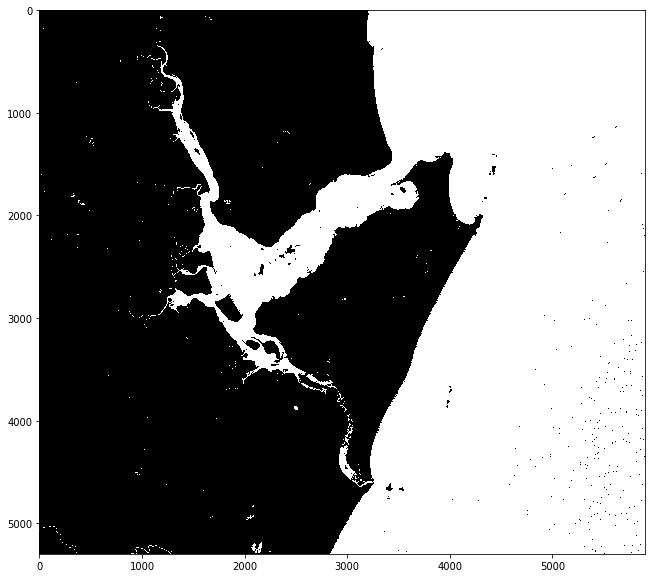

In [33]:
plt.figure(figsize=(12,10))
plt.imshow(water_filter, "gray")

### Imagem rgb usada para visualização final

In [16]:
bgr_image = np.dstack((b2,b3,b4))
bgr_image = bgr_image + 0.1
bgr_image = bgr_image.clip(0,1)

In [17]:
bgr_image = (bgr_image*255.99).astype(np.uint8)

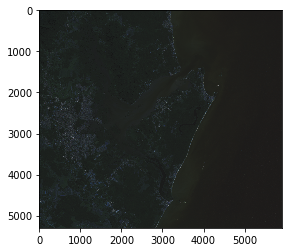

In [18]:
plt.imshow(bgr_image)

In [19]:
cv2.imwrite("rgbresult.jpg", bgr_image)

True

In [20]:
import joblib as jb
from lightgbm import LGBMRegressor
import colorsys

## 3. Carregar modelo treinado

In [21]:
jbpath = "lgbm_baseline.pkl.z"

In [22]:
lgbm = jb.load(jbpath)

Relação de tamanho da imagem da banda 7 diferente das outras

In [50]:
b7fix = b7.shape[0]/float(b1.shape[0])
b7fix

0.6647791619479049

In [23]:
p = get_pixel_from_coord(720507.82,7089857.17, scale_x, scale_y, start_value_x, start_value_y)
i = p[1]
j = p[0]
np.array([b6[i][j],b5[i][j],b4[i][j],b2[i][j],b3[i][j],b7[i][j],b8[i][j],b1[i][j]]).reshape(1,-1)

array([[0.02080799, 0.03994652, 0.03129008, 0.02129183, 0.0374453 ,
        0.20355827, 0.01701066, 0.01462582]], dtype=float32)

### Carregar a região de água de todas as bandas em dataframe

In [53]:
b7fix = b7.shape[0]/float(b1.shape[0])

aux = list()
for i in tqdm.tqdm(range(bgr_image.shape[0])):
    for j in range(bgr_image.shape[1]):
        if ndwib3b8[i][j]:
            aux.append(np.array([j,i,b6[i][j],b5[i][j],b4[i][j],b2[i][j],b3[i][j],b7[int(np.clip(i*b7fix,0,b7.shape[0]))][j],b8[i][j],b1[i][j]]))
            









  0%|                                                                                         | 0/5298 [00:00<?, ?it/s]







  0%|                                                                                 | 4/5298 [00:00<02:31, 34.87it/s]







  0%|                                                                                 | 8/5298 [00:00<02:29, 35.33it/s]







  0%|▏                                                                               | 12/5298 [00:00<02:28, 35.66it/s]







  0%|▏                                                                               | 16/5298 [00:00<02:27, 35.75it/s]







  0%|▎                                                                               | 20/5298 [00:00<02:26, 36.13it/s]







  0%|▎                                                                               | 24/5298 [00:00<02:25, 36.23it/s]







  1%|▍                                                                               | 28/5298 [00:00<0

 10%|███████▋                                                                       | 512/5298 [00:14<02:19, 34.21it/s]







 10%|███████▋                                                                       | 516/5298 [00:14<02:18, 34.41it/s]







 10%|███████▊                                                                       | 520/5298 [00:14<02:19, 34.19it/s]







 10%|███████▊                                                                       | 524/5298 [00:15<02:18, 34.39it/s]







 10%|███████▊                                                                       | 528/5298 [00:15<02:20, 33.92it/s]







 10%|███████▉                                                                       | 532/5298 [00:15<02:18, 34.29it/s]







 10%|███████▉                                                                       | 536/5298 [00:15<02:17, 34.68it/s]







 10%|████████                                                                       | 540/5298 [00:15<02:14, 35

 19%|███████████████                                                               | 1024/5298 [00:28<01:55, 36.94it/s]







 19%|███████████████▏                                                              | 1028/5298 [00:28<01:55, 37.00it/s]







 19%|███████████████▏                                                              | 1032/5298 [00:28<01:56, 36.53it/s]







 20%|███████████████▎                                                              | 1036/5298 [00:29<01:55, 36.81it/s]







 20%|███████████████▎                                                              | 1040/5298 [00:29<01:55, 36.86it/s]







 20%|███████████████▎                                                              | 1044/5298 [00:29<01:54, 37.04it/s]







 20%|███████████████▍                                                              | 1048/5298 [00:29<01:57, 36.17it/s]







 20%|███████████████▍                                                              | 1052/5298 [00:29<01:56, 36

 29%|██████████████████████▉                                                       | 1556/5298 [00:42<01:24, 44.08it/s]







 29%|██████████████████████▉                                                       | 1561/5298 [00:42<01:25, 43.70it/s]







 30%|███████████████████████                                                       | 1566/5298 [00:43<01:26, 43.33it/s]







 30%|███████████████████████▏                                                      | 1571/5298 [00:43<01:26, 43.19it/s]







 30%|███████████████████████▏                                                      | 1576/5298 [00:43<01:27, 42.76it/s]







 30%|███████████████████████▎                                                      | 1581/5298 [00:43<01:27, 42.52it/s]







 30%|███████████████████████▎                                                      | 1586/5298 [00:43<01:27, 42.47it/s]







 30%|███████████████████████▍                                                      | 1591/5298 [00:43<01:27, 42

 39%|██████████████████████████████▋                                               | 2085/5298 [00:57<01:21, 39.44it/s]







 39%|██████████████████████████████▊                                               | 2089/5298 [00:57<01:21, 39.29it/s]







 40%|██████████████████████████████▊                                               | 2094/5298 [00:57<01:20, 39.91it/s]







 40%|██████████████████████████████▉                                               | 2099/5298 [00:57<01:19, 40.35it/s]







 40%|██████████████████████████████▉                                               | 2104/5298 [00:57<01:19, 40.38it/s]







 40%|███████████████████████████████                                               | 2109/5298 [00:57<01:19, 40.30it/s]







 40%|███████████████████████████████                                               | 2114/5298 [00:58<01:18, 40.48it/s]







 40%|███████████████████████████████▏                                              | 2119/5298 [00:58<01:18, 40

 49%|██████████████████████████████████████▌                                       | 2616/5298 [01:12<01:15, 35.58it/s]







 49%|██████████████████████████████████████▌                                       | 2620/5298 [01:12<01:15, 35.36it/s]







 50%|██████████████████████████████████████▋                                       | 2624/5298 [01:12<01:15, 35.49it/s]







 50%|██████████████████████████████████████▋                                       | 2628/5298 [01:12<01:19, 33.54it/s]







 50%|██████████████████████████████████████▋                                       | 2632/5298 [01:12<01:18, 34.10it/s]







 50%|██████████████████████████████████████▊                                       | 2636/5298 [01:12<01:16, 34.68it/s]







 50%|██████████████████████████████████████▊                                       | 2640/5298 [01:12<01:16, 34.74it/s]







 50%|██████████████████████████████████████▉                                       | 2644/5298 [01:12<01:15, 35

 60%|██████████████████████████████████████████████▉                               | 3190/5298 [01:26<00:51, 40.84it/s]







 60%|███████████████████████████████████████████████                               | 3195/5298 [01:26<00:51, 40.72it/s]







 60%|███████████████████████████████████████████████                               | 3200/5298 [01:27<00:51, 40.43it/s]







 60%|███████████████████████████████████████████████▏                              | 3205/5298 [01:27<00:51, 40.38it/s]







 61%|███████████████████████████████████████████████▎                              | 3210/5298 [01:27<00:51, 40.39it/s]







 61%|███████████████████████████████████████████████▎                              | 3215/5298 [01:27<00:51, 40.40it/s]







 61%|███████████████████████████████████████████████▍                              | 3220/5298 [01:27<00:51, 40.54it/s]







 61%|███████████████████████████████████████████████▍                              | 3225/5298 [01:27<00:50, 41

 71%|███████████████████████████████████████████████████████▊                      | 3788/5298 [01:41<00:34, 43.15it/s]







 72%|███████████████████████████████████████████████████████▊                      | 3793/5298 [01:41<00:34, 43.22it/s]







 72%|███████████████████████████████████████████████████████▉                      | 3798/5298 [01:41<00:34, 43.33it/s]







 72%|███████████████████████████████████████████████████████▉                      | 3803/5298 [01:41<00:34, 43.53it/s]







 72%|████████████████████████████████████████████████████████                      | 3808/5298 [01:42<00:34, 43.43it/s]







 72%|████████████████████████████████████████████████████████▏                     | 3813/5298 [01:42<00:34, 43.41it/s]







 72%|████████████████████████████████████████████████████████▏                     | 3818/5298 [01:42<00:34, 43.52it/s]







 72%|████████████████████████████████████████████████████████▎                     | 3823/5298 [01:42<00:33, 43

 83%|████████████████████████████████████████████████████████████████▌             | 4383/5298 [01:56<00:23, 39.43it/s]







 83%|████████████████████████████████████████████████████████████████▌             | 4387/5298 [01:56<00:23, 39.28it/s]







 83%|████████████████████████████████████████████████████████████████▋             | 4391/5298 [01:56<00:23, 39.18it/s]







 83%|████████████████████████████████████████████████████████████████▋             | 4395/5298 [01:57<00:23, 38.94it/s]







 83%|████████████████████████████████████████████████████████████████▊             | 4399/5298 [01:57<00:23, 38.93it/s]







 83%|████████████████████████████████████████████████████████████████▊             | 4403/5298 [01:57<00:22, 38.93it/s]







 83%|████████████████████████████████████████████████████████████████▉             | 4407/5298 [01:57<00:23, 38.49it/s]







 83%|████████████████████████████████████████████████████████████████▉             | 4411/5298 [01:57<00:23, 38

 93%|████████████████████████████████████████████████████████████████████████▏     | 4901/5298 [02:11<00:10, 36.53it/s]







 93%|████████████████████████████████████████████████████████████████████████▏     | 4905/5298 [02:11<00:10, 36.31it/s]







 93%|████████████████████████████████████████████████████████████████████████▎     | 4909/5298 [02:11<00:10, 36.31it/s]







 93%|████████████████████████████████████████████████████████████████████████▎     | 4913/5298 [02:11<00:10, 35.96it/s]







 93%|████████████████████████████████████████████████████████████████████████▍     | 4917/5298 [02:11<00:10, 35.54it/s]







 93%|████████████████████████████████████████████████████████████████████████▍     | 4921/5298 [02:11<00:10, 35.52it/s]







 93%|████████████████████████████████████████████████████████████████████████▌     | 4925/5298 [02:11<00:10, 35.42it/s]







 93%|████████████████████████████████████████████████████████████████████████▌     | 4929/5298 [02:12<00:10, 35

In [55]:
dfaux = pd.DataFrame(aux)

ValueError: Length mismatch: Expected axis has 10 elements, new values have 11 elements

In [57]:
dfaux.columns = ["px","py","b6","b5","b4","b2","b3","b7","b8","b1"]

## 4. Predição dos pontos não conhecidos

In [60]:
z = lgbm.predict(dfaux.drop(["px","py"],axis=1))

In [62]:
dfaux["z"] = z

In [83]:
dfaux["z"].describe()

count    1.339560e+07
mean     2.014893e+01
std      5.638718e+00
min     -2.859339e+00
25%      1.887177e+01
50%      2.194745e+01
75%      2.362718e+01
max      3.908326e+01
Name: z, dtype: float64

In [ ]:
dfauxpath = "dfaux.pkl.z"

In [64]:
jb.dump(dfaux,dfauxpath)

['dfaux.pkl.z']

In [ ]:
dfaux = jb.load(dfauxpath)

### Usar somente de 0 até 78% do H da escala HSL para cores

In [205]:
depth_max = 50
ratio_between_max_and_depth_max = dfaux["z"].max()/depth_max
ratio_between_max_and_depth_max

0.7816652915580857

In [206]:
output = bgr_image.copy()
for i, row in tqdm.tqdm(enumerate(dfaux.itertuples())):
    x = int(row[1])
    y = int(row[2])
    z = row[11]
    output[y][x] = [int(e*255) for e in (colorsys.hls_to_rgb(z/depth_max, 0.5, 1))]










0it [00:00, ?it/s]








15150it [00:00, 151134.77it/s]








32081it [00:00, 156060.03it/s]








47817it [00:00, 156336.30it/s]








66039it [00:00, 163270.91it/s]








85057it [00:00, 170159.93it/s]








104333it [00:00, 176025.40it/s]








121663it [00:00, 174811.19it/s]








138009it [00:00, 170843.17it/s]








154919it [00:00, 169936.99it/s]








171416it [00:01, 168036.07it/s]








189334it [00:01, 170872.18it/s]








208446it [00:01, 176136.39it/s]








227418it [00:01, 179634.16it/s]








246443it [00:01, 182533.85it/s]








265511it [00:01, 184509.69it/s]








285020it [00:01, 187287.66it/s]








304350it [00:01, 188629.79it/s]








323211it [00:01, 183680.81it/s]








342640it [00:01, 186625.11it/s]








361333it [00:02, 184924.23it/s]








379851it [00:02, 182945.53it/s]








399072it [00:02, 185252.14it/s]








418838it [00:02, 188413.42it/s]








438673it [00:02, 190867.67it/s]








457788it 

7626036it [00:41, 193456.30it/s]








7645408it [00:41, 172070.52it/s]








7663072it [00:41, 159057.25it/s]








7680319it [00:41, 162520.85it/s]








7699467it [00:41, 170031.95it/s]








7719340it [00:42, 177372.72it/s]








7738711it [00:42, 181839.27it/s]








7758471it [00:42, 186169.65it/s]








7778363it [00:42, 189421.87it/s]








7797872it [00:42, 190677.90it/s]








7817979it [00:42, 193290.56it/s]








7838154it [00:42, 195337.78it/s]








7858028it [00:42, 195921.31it/s]








7877817it [00:42, 196063.62it/s]








7897780it [00:42, 196692.69it/s]








7917594it [00:43, 196715.55it/s]








7937283it [00:43, 196572.60it/s]








7956993it [00:43, 196299.50it/s]








7977034it [00:43, 197071.18it/s]








7996748it [00:43, 196075.64it/s]








8016655it [00:43, 196538.47it/s]








8036596it [00:43, 197215.47it/s]








8056447it [00:43, 197448.31it/s]








8076195it [00:43, 197440.22it/s]








8095941it [00:43

In [207]:
output = cv2.cvtColor(output,cv2.COLOR_BGR2RGB)

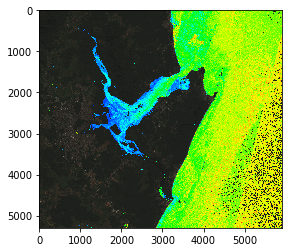

In [208]:
plt.imshow(output)

In [209]:
cv2.imwrite("predictResult.jpg", output)

True

In [212]:
frame = output.copy()

## 5. Label de escala de profundidade

In [235]:
frame = output.copy()
posx = 0.98
posy = 0.4
height = 0.4
width = 0.1
minDepth = 0
maxDepth = 40
spacing = 5
intervals = int((maxDepth - minDepth)/spacing) + 1

h = int(output.shape[1]*height)
w = int(output.shape[0]*width)
x = int(output.shape[0]*posx)
y = int(output.shape[1]*posy)
cv2.rectangle(frame, (x, y), (x+w,y+h), (255, 255, 255), -1)

cv2.rectangle(frame, (x, y-300), (x+w,y), (255, 255, 255), -1)


font = cv2.FONT_HERSHEY_COMPLEX
fontScale = 4
color = (0, 0, 0)
thickness = 4


pos = (x+50, y-180)
cv2.putText(frame, "Depth", pos, font, fontScale, color, thickness, cv2.LINE_AA)
pos = (x+50, y-40)
fontScale = 3
cv2.putText(frame, "(meters)", pos, font, fontScale, color, thickness, cv2.LINE_AA)

fontScale = 4
for i in range(intervals):
    pos = (x+280, y+150+int(i*h/intervals))
    cv2.putText(frame, str(i*spacing), pos, font, fontScale, color, thickness, cv2.LINE_AA)

iterations = int(maxDepth-minDepth)*100
for i in range(iterations):
    color = [int(e*255) for e in (colorsys.hls_to_rgb(ratio_between_max_and_depth_max*(i/100)/depth_max, 0.5, 1))]
    cv2.rectangle(frame, (x+50, y+int(0.96*h*(i/iterations))+50), (x+int(w/2.5),y+int(0.96*h*(i/iterations))+51), color[::-1], -1)
    

In [236]:
cv2.imwrite("scaleimg_rhow.jpg", frame)

True